In [1]:
from sklearn import linear_model
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# The Propublica Data Set

Below, `allowed_factors` shows all of the data that the Propublica data set contains with $\sim$ 7000 people. I have commented out the factors that I do not think are appropriate or seem useless for predicting recidivism. I have also left in variables dealing with recidivism--whether or not it was violent and whether it was a misdemeanor or felony. If it is unclear what a variable is, I put a comment indicating what I think it is. I kept `race` and `decile_score` in to do analysis later.

In [2]:
raw_data = pd.read_csv("./compas-scores-two-years.csv")

In [3]:
allowed_factors = [
 #'id',
 #'name',
 #'first',
 #'last',
 #'compas_screening_date',
 #'sex',
 #'dob',
 #'age',
 #'age_cat',
 'race',
 'decile_score', #i think? this is the compass score?
 'juv_fel_count', 
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 #'days_b_screening_arrest', not really sure what this is but propublica uses it to filter data
#  'c_jail_in', date
#  'c_jail_out', date
#  'c_case_number',
#  'c_offense_date',
#  'c_arrest_date',
#  'c_days_from_compas',
 'c_charge_degree', #SHOULD MAKE THIS CATEGORICAL
 #'c_charge_desc',
 'is_recid', 
 #'r_case_number',
 'r_charge_degree',#SHOULD MAKE THIS CATEGORICAL
#  'r_days_from_arrest',
#  'r_offense_date',
#  'r_charge_desc',
#  'r_jail_in',
#  'r_jail_out',
 #'violent_recid', #all are NAN
 'is_violent_recid', #hey we can use this for groups!
#  'vr_case_number',
 'vr_charge_degree', #maybe remove this from r_charge degree
#  'vr_offense_date',
#  'vr_charge_desc', #weird that vr_charge_desc and r_charge_desc do not overlap
#  'type_of_assessment',
#  'decile_score.1',#same as decile score?
  'score_text',
#  'screening_date',
#  'v_type_of_assessment',
#  'v_decile_score',
#  'v_score_text', #low, medium high
#  'v_screening_date',
#  'in_custody',
#  'out_custody',
 #'priors_count.1', #not sure what the dif is from priors_count. it is the same
#  'start',
#  'end',
# 'event', #no clue what this means?!? ***
 #'two_year_recid' # same as is_recid
] 

In [4]:
allowed_factors

['race',
 'decile_score',
 'juv_fel_count',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'c_charge_degree',
 'is_recid',
 'r_charge_degree',
 'is_violent_recid',
 'vr_charge_degree',
 'score_text']

If you want to see what the other columns of `raw_data` are, play with the below cell:

In [5]:
raw_data[['is_recid', 'r_charge_degree']]

,is_recid,r_charge_degree
0,0,NaN
1,1,(F3)
2,1,(M1)
3,0,NaN
4,0,NaN
5,0,NaN
6,1,(F2)
7,0,NaN
8,0,NaN
9,1,(M1)


I have filtered the data just as Propublica has but I only include African Americans and Caucasians leaving $\sim$ 5000 people.

In [6]:
filtered_data = raw_data.loc[(raw_data['is_recid'] != -1) & 
                             (raw_data['days_b_screening_arrest'] <=30) &
                             (raw_data['days_b_screening_arrest'] >=-30) &
                             (raw_data['c_charge_degree'] != 'O') &
                             (raw_data['score_text'] != 'N/A') &
                             (raw_data['race'].isin(['African-American', 'Caucasian']))
                            ]
final_data = filtered_data[allowed_factors]
print('the dimensions of final_data are', final_data.shape)

the dimensions of final_data are (5278, 12)


In [7]:
# shuffle data
final_data = final_data.sample(frac=1).reset_index(drop=True)

In [8]:
# get data
Y = final_data[allowed_factors].values[:, 7:11]
X = final_data[allowed_factors].values[:, 2:7]
compas = final_data[allowed_factors].values[:, 1]
race = final_data[allowed_factors].values[:, 0]
score_text = final_data[allowed_factors].values[:, 11]

# change Misdemeanor/Felony to 0/1
keys = {}
value = 0;
for t,i in enumerate(X[:,4]):
    if i not in keys:
        keys[i] = value
        value +=1
    X[t, 4] = keys[i]

In [9]:
#split data into debias train; train; test
debias_train_size = 1000
train_size = math.floor((X.shape[0] - debias_train_size)*.6)
test_size = (X.shape[0] - debias_train_size) - math.floor((X.shape[0] - debias_train_size)*.6)

X_debias_train = X[0:debias_train_size, :]
Y_debias_train = Y[0:debias_train_size, :]


X_train = X[debias_train_size : debias_train_size + train_size, : ]
Y_train = Y[debias_train_size : debias_train_size + train_size, : ]
race_train = race[debias_train_size : debias_train_size + train_size ]

X_test = X[debias_train_size + train_size:, :]
Y_test = Y[debias_train_size + train_size:, :]
compas_test = compas[debias_train_size + train_size:]
race_test = race[debias_train_size + train_size:]

In [10]:
# quick check to make sure I split the data correctly
print('size of X:', X.shape[0])
print('size of train_debias + train + test:', X_debias_train.shape[0] + X_train.shape[0] + X_test.shape[0])

size of X: 5278
size of train_debias + train + test: 5278


## Logistic Regression

In [11]:
# fit logistic regression

#had to do this because of some error...
y = [int(Y_train[i,0]) for i in range(Y_train.shape[0])]

lr = linear_model.LogisticRegression()
lr.fit(X_train,y)
w = lr.coef_
w = np.array(w)
b = lr.intercept_

def logistic(w, X,b):
    return 1/(1+ math.exp(-(np.dot(w,X.T) + b)))

## Quality of the Logistic Regression Model & COMPAS on Test Set

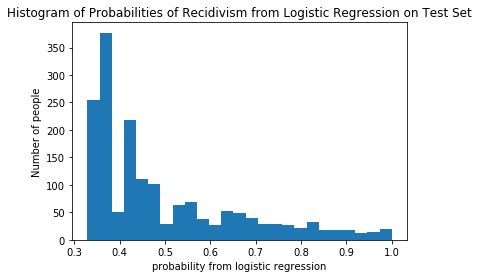

Notice the difference in scale on the y-axis!


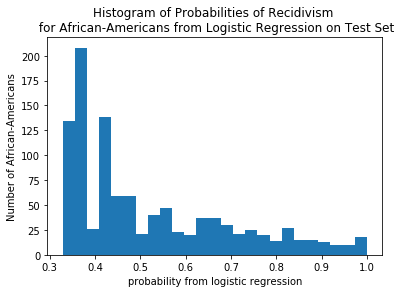

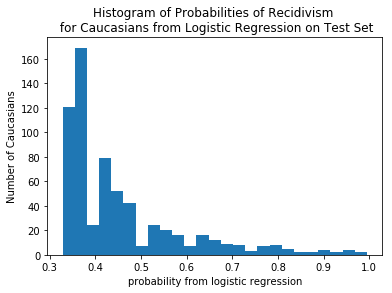

In [12]:
probabilities = [logistic(w, X_test[i,:],b) for i in range(X_test.shape[0])]
plt.hist(probabilities, bins = 25)
plt.title("Histogram of Probabilities of Recidivism from Logistic Regression on Test Set")
plt.xlabel("probability from logistic regression")
plt.ylabel("Number of people")
plt.show()

print('Notice the difference in scale on the y-axis!')
probabilities_AA = [logistic(w, X_test[i,:],b) for i in range(X_test.shape[0]) if race_test[i] == 'African-American']
probabilities_white = [logistic(w, X_test[i,:],b) for i in range(X_test.shape[0]) if race_test[i] == 'Caucasian']

plt.hist(probabilities_AA, bins = 25)
plt.title("Histogram of Probabilities of Recidivism \n for African-Americans from Logistic Regression on Test Set")
plt.xlabel("probability from logistic regression")
plt.ylabel("Number of African-Americans")
plt.show()

plt.hist(probabilities_white, bins = 25)
plt.title("Histogram of Probabilities of Recidivism \n for Caucasians from Logistic Regression on Test Set")
plt.xlabel("probability from logistic regression")
plt.ylabel("Number of Caucasians")
plt.show()

In [13]:
np.mean(probabilities)

0.49443576408879275

In [14]:
logistic_prob_threshold = .5
compass_score_threshold = 5

num_true_pos = 0
num_COMP_FP = 0
num_COMP_TP = 0
num_LR_FP = 0
num_LR_TP = 0
num_true_neg = 0
num_COMP_FN = 0
num_COMP_TN = 0 
num_LR_FN = 0
num_LR_TN = 0 

#for whites
num_true_pos_W = 0
num_true_neg_W = 0
num_true_pos_W = 0
num_COMP_FP_W = 0
num_COMP_TP_W = 0
num_LR_FP_W = 0
num_LR_TP_W = 0
num_true_neg_W = 0
num_COMP_FN_W = 0
num_COMP_TN_W = 0 
num_LR_FN_W = 0
num_LR_TN_W = 0 

#for blacks
num_true_pos_B = 0
num_true_neg_B = 0
num_true_pos_B = 0
num_COMP_FP_B = 0
num_COMP_TP_B = 0
num_LR_FP_B = 0
num_LR_TP_B = 0
num_true_neg_B = 0
num_COMP_FN_B = 0
num_COMP_TN_B = 0 
num_LR_FN_B = 0
num_LR_TN_B = 0 

#sorry this is ugly. i prob could have made it better :/
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 0:
        num_true_neg +=1
        if race_test[i] == 'Caucasian':
            num_true_neg_W +=1
        else:
            num_true_neg_B +=1
        #compass
        if int(compas_test[i]) >=compass_score_threshold:
            num_COMP_FP +=1
            if race_test[i] == 'Caucasian':
                num_COMP_FP_W +=1
            else:
                num_COMP_FP_B +=1
        else: 
            num_COMP_TN +=1
            if race_test[i] == 'Caucasian':
                num_COMP_TN_W +=1
            else:
                num_COMP_TN_B +=1
                
        #logistic
        if probabilities[i] > logistic_prob_threshold:
            num_LR_FP +=1
            if race_test[i] == 'Caucasian':
                num_LR_FP_W +=1
            else:
                num_LR_FP_B +=1
        else: 
            num_LR_TN +=1
            if race_test[i] == 'Caucasian':
                num_LR_TN_W +=1
            else:
                num_LR_TN_B +=1
            
    elif Y_test[i,0] == 1:
        num_true_pos += 1
        if race_test[i] == 'Caucasian':
            num_true_pos_W +=1
        else:
            num_true_pos_B +=1
        #compass
        if int(compas_test[i]) < compass_score_threshold:
            num_COMP_FN +=1
            if race_test[i] == 'Caucasian':
                num_COMP_FN_W +=1
            else:
                num_COMP_FN_B +=1
        else:
            num_COMP_TP +=1
            if race_test[i] == 'Caucasian':
                num_COMP_TP_W +=1
            else:
                num_COMP_TP_B +=1
        
            
        #logistic
        if probabilities[i] < logistic_prob_threshold:
            num_LR_FN +=1
            if race_test[i] == 'Caucasian':
                num_LR_FN_W +=1
            else:
                num_LR_FN_B +=1            
        else:
            num_LR_TP +=1
            if race_test[i] == 'Caucasian':
                num_LR_TP_W +=1
            else:
                num_LR_TP_B +=1
    
print('There are', num_true_neg, 'people who did NOT recidivate within 2 years on the test set.')
print('There are', num_true_pos, 'people who DID recidivate within 2 years on the test set.', '\n')
 
print('There are', num_true_neg_W, 'Caucasians who did NOT recidivate within 2 years on the test set.')
print('There are', num_true_pos_W, 'Caucasians who DID recidivate within 2 years on the test set.', '\n')

print('There are', num_true_neg_B, 'African-Americans who did NOT recidivate within 2 years on the test set.')
print('There are', num_true_pos_B, 'African-Americans who DID recidivate within 2 years on the test set.', '\n')
print('--------------------------------------------------------------------------------------')
print('The COMPAS false positive rate on the entire test set is', num_COMP_FP / (num_true_neg))
print('The COMPAS false negative rate on the entire test set is', num_COMP_FN / (num_true_pos), '\n')

print('The COMPAS false positive rate on Caucasians in the test set is', num_COMP_FP_W / (num_COMP_FP_W + num_COMP_TN_W))
print('The COMPAS false negative rate on Caucasians in the test set is', num_COMP_FN_W / (num_COMP_FN_W + num_COMP_TP_W), '\n')

print('The COMPAS false positive rate on African-Americans in the test set is', num_COMP_FP_B / (num_COMP_FP_B + num_COMP_TN_B))
print('The COMPAS false negative rate on African-Americans in the test set is', num_COMP_FN_B / (num_COMP_FN_B + num_COMP_TP_B), '\n')
print('--------------------------------------------------------------------------------------')
print('Logistic Regression false positive rate on the entire test set is', num_LR_FP / (num_true_neg))
print('Logistic Regression false negative rate on the entire test set  is', num_LR_FN / (num_true_pos), '\n')

print('Logistic Regression false positive rate on Caucasians in the test set is', num_LR_FP_W / (num_LR_FP_W + num_LR_TN_W))
print('Logistic Regression false negative rate on Caucasians in the test set is', num_LR_FN_W / (num_LR_FN_W + num_LR_TP_W), '\n')

print('Logistic Regression false positive rate on African-Americans in the test set is', num_LR_FP_B / (num_LR_FP_B + num_LR_TN_B))
print('Logistic Regression false negative rate on African-Americans in the test set is', num_LR_FN_B / (num_LR_FN_B + num_LR_TP_B), '\n')

        

There are 831 people who did NOT recidivate within 2 years on the test set.
There are 881 people who DID recidivate within 2 years on the test set. 

There are 369 Caucasians who did NOT recidivate within 2 years on the test set.
There are 276 Caucasians who DID recidivate within 2 years on the test set. 

There are 462 African-Americans who did NOT recidivate within 2 years on the test set.
There are 605 African-Americans who DID recidivate within 2 years on the test set. 

--------------------------------------------------------------------------------------
The COMPAS false positive rate on the entire test set is 0.32731648616125153
The COMPAS false negative rate on the entire test set is 0.38024971623155507 

The COMPAS false positive rate on Caucasians in the test set is 0.21138211382113822
The COMPAS false negative rate on Caucasians in the test set is 0.5398550724637681 

The COMPAS false positive rate on African-Americans in the test set is 0.4199134199134199
The COMPAS false n

# Unbiasing Recidivism Scores

We assume that the data $Y = X A^T + Z B^T + E$, where $X$ is protected attributes like gender, $Z$ are unknown but are "discriminative" attributes and $E$ is an error term. 

We partition the rows of $Y$ into 3 "homogeneous groups": 
<ol>
  <li>Those who have committed a **non-violent** crime within 2 years.</li>
  <li>Those who have committed a **violent** crime within 2 years</li>
  <li>Those who have **not** committed a crime after 2 years.</li>
</ol>

We remark that we do not consider those who are not released from a correctional facility because we do not have knowledge about whether they would or would not have committed a crime.

To debias the data, we use least squares to estimate $A$.

In [15]:
race_dict = {'Caucasian': 0, 'African-American':1}
race_encoded_train = np.array([race_dict[i] for i in race_train]).reshape((-1,1))
race_encoded_test = np.array([race_dict[i] for i in race_test]).reshape((-1,1))

In [16]:
def add_vec(a,b):
    c=np.copy(a)
    for i in range(len(a)):
        c[i] += b[i]
    return c

def subtract_vec(a,b):
    c=np.copy(a)
    for i in range(len(a)):
        c[i] -= b[i]
    return c    

In [17]:
#can also break into felony or misdemenor

#get average race in each group
nonviolent_avg_race_train = np.mean(np.array([race_encoded_train[i] for i in range(len(race_encoded_train)) if Y_train[i,0] == 1 and Y_train[i,2]==0]))
violent_avg_race_train = np.mean(np.array([race_encoded_train[i] for i in range(len(race_encoded_train)) if Y_train[i,2]==1]))
nonrecidiv_avg_race_train = np.mean(np.array([race_encoded_train[i] for i in range(len(race_encoded_train)) if Y_train[i,0]==0]))

#get average "Y" in alg 1 in our paper for each group
nonviolent_avg_X_train = np.zeros(X_train.shape[1])
count = 0
for i in range(X_train.shape[0]):
    if Y_train[i,0] == 1 and Y_train[i,2] == 0:
        count +=1
        nonviolent_avg_X_train = add_vec(nonviolent_avg_X_train,X_train[i,:])

nonviolent_avg_X_train = nonviolent_avg_X_train/count
############################################
violent_avg_X_train = np.zeros(X_train.shape[1])
count = 0
for i in range(X_train.shape[0]):
    if Y_train[i,2] == 1:
        count +=1
        violent_avg_X_train = add_vec(violent_avg_X_train,X_train[i,:])

violent_avg_X_train = violent_avg_X_train/count
###########################################
nonrecidiv_avg_X_train = np.zeros(X_train.shape[1])
count = 0
for i in range(X_train.shape[0]):
    if Y_train[i,2] == 1:
        count +=1
        nonrecidiv_avg_X_train = add_vec(nonrecidiv_avg_X_train,X_train[i,:])

nonrecidiv_avg_X_train = nonrecidiv_avg_X_train/count

#get centered matrices
race_encoded_train_centered = np.zeros(race_encoded_train.shape)
X_train_centered = X_train
for i in range(X_train.shape[0]):
    if Y_train[i,0] == 1 and Y_train[i,2] == 0:
        race_encoded_train_centered[i,0] = race_encoded_train[i,0] - nonviolent_avg_race_train
        X_train_centered[i,:] = np.copy(subtract_vec(X_train_centered[i,:], nonviolent_avg_X_train))
    elif Y_train[i,2] == 1:
        race_encoded_train_centered[i,0] = race_encoded_train[i,0] - violent_avg_race_train
        X_train_centered[i,:] = np.copy(subtract_vec(X_train_centered[i,:], violent_avg_X_train))
    else:
        race_encoded_train_centered[i,0] = race_encoded_train[i,0] - nonrecidiv_avg_race_train
        X_train_centered[i,:] = np.copy(subtract_vec(X_train_centered[i,:], nonrecidiv_avg_X_train))
        


In [18]:
# 'is_recid',
#  'r_charge_degree',
#  'is_violent_recid',
#  'vr_charge_degree',

In [19]:
ols = linear_model.LinearRegression(fit_intercept=False)
ols.fit(race_encoded_train_centered, X_train_centered)
A_hat = ols.coef_

## Debiased Recidivism Scores

We will use logistic regression again.

In [20]:
X_debias_train = X_train - np.dot(race_encoded_train,A_hat.T)
X_debias_test = X_test - np.dot(race_encoded_test, A_hat.T)
# fit logistic regression

#had to do this because of some error...
y = [int(Y_train[i,0]) for i in range(Y_train.shape[0])]

lr = linear_model.LogisticRegression()
lr.fit(X_debias_train,y)
w = lr.coef_
w = np.array(w)
b = lr.intercept_

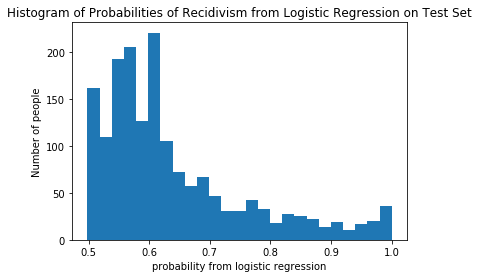

Notice the difference in scale on the y-axis!


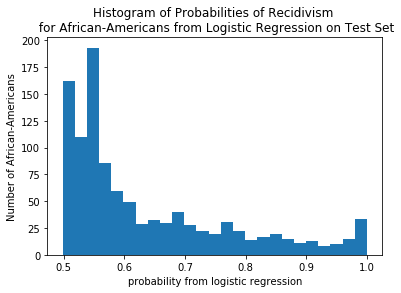

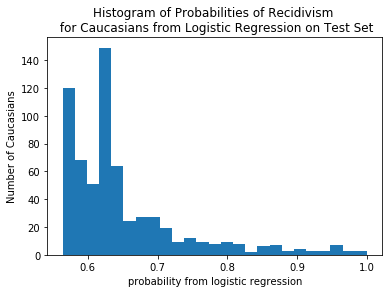

In [21]:
probabilities = [logistic(w, X_debias_test[i,:],b) for i in range(X_debias_test.shape[0])]
plt.hist(probabilities, bins = 25)
plt.title("Histogram of Probabilities of Recidivism from Logistic Regression on Test Set")
plt.xlabel("probability from logistic regression")
plt.ylabel("Number of people")
plt.show()

print('Notice the difference in scale on the y-axis!')
probabilities_AA = [logistic(w, X_debias_test[i,:],b) for i in range(X_debias_test.shape[0]) if race_test[i] == 'African-American']
probabilities_white = [logistic(w, X_debias_test[i,:],b) for i in range(X_debias_test.shape[0]) if race_test[i] == 'Caucasian']

plt.hist(probabilities_AA, bins = 25)
plt.title("Histogram of Probabilities of Recidivism \n for African-Americans from Logistic Regression on Test Set")
plt.xlabel("probability from logistic regression")
plt.ylabel("Number of African-Americans")
plt.show()

plt.hist(probabilities_white, bins = 25)
plt.title("Histogram of Probabilities of Recidivism \n for Caucasians from Logistic Regression on Test Set")
plt.xlabel("probability from logistic regression")
plt.ylabel("Number of Caucasians")
plt.show()

In [22]:
logistic_prob_threshold = .7
compass_score_threshold = 5

num_true_pos = 0
num_COMP_FP = 0
num_COMP_TP = 0
num_LR_FP = 0
num_LR_TP = 0
num_true_neg = 0
num_COMP_FN = 0
num_COMP_TN = 0 
num_LR_FN = 0
num_LR_TN = 0 

#for whites
num_true_pos_W = 0
num_true_neg_W = 0
num_true_pos_W = 0
num_COMP_FP_W = 0
num_COMP_TP_W = 0
num_LR_FP_W = 0
num_LR_TP_W = 0
num_true_neg_W = 0
num_COMP_FN_W = 0
num_COMP_TN_W = 0 
num_LR_FN_W = 0
num_LR_TN_W = 0 

#for blacks
num_true_pos_B = 0
num_true_neg_B = 0
num_true_pos_B = 0
num_COMP_FP_B = 0
num_COMP_TP_B = 0
num_LR_FP_B = 0
num_LR_TP_B = 0
num_true_neg_B = 0
num_COMP_FN_B = 0
num_COMP_TN_B = 0 
num_LR_FN_B = 0
num_LR_TN_B = 0 

#sorry this is ugly. i prob could have made it better :/
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 0:
        num_true_neg +=1
        if race_test[i] == 'Caucasian':
            num_true_neg_W +=1
        else:
            num_true_neg_B +=1
        #compass
        if int(compas_test[i]) >=compass_score_threshold:
            num_COMP_FP +=1
            if race_test[i] == 'Caucasian':
                num_COMP_FP_W +=1
            else:
                num_COMP_FP_B +=1
        else: 
            num_COMP_TN +=1
            if race_test[i] == 'Caucasian':
                num_COMP_TN_W +=1
            else:
                num_COMP_TN_B +=1
                
        #logistic
        if probabilities[i] > logistic_prob_threshold:
            num_LR_FP +=1
            if race_test[i] == 'Caucasian':
                num_LR_FP_W +=1
            else:
                num_LR_FP_B +=1
        else: 
            num_LR_TN +=1
            if race_test[i] == 'Caucasian':
                num_LR_TN_W +=1
            else:
                num_LR_TN_B +=1
            
    elif Y_test[i,0] == 1:
        num_true_pos += 1
        if race_test[i] == 'Caucasian':
            num_true_pos_W +=1
        else:
            num_true_pos_B +=1
        #compass
        if int(compas_test[i]) < compass_score_threshold:
            num_COMP_FN +=1
            if race_test[i] == 'Caucasian':
                num_COMP_FN_W +=1
            else:
                num_COMP_FN_B +=1
        else:
            num_COMP_TP +=1
            if race_test[i] == 'Caucasian':
                num_COMP_TP_W +=1
            else:
                num_COMP_TP_B +=1
        
            
        #logistic
        if probabilities[i] < logistic_prob_threshold:
            num_LR_FN +=1
            if race_test[i] == 'Caucasian':
                num_LR_FN_W +=1
            else:
                num_LR_FN_B +=1            
        else:
            num_LR_TP +=1
            if race_test[i] == 'Caucasian':
                num_LR_TP_W +=1
            else:
                num_LR_TP_B +=1
    
print('There are', num_true_neg, 'people who did NOT recidivate within 2 years on the test set.')
print('There are', num_true_pos, 'people who DID recidivate within 2 years on the test set.', '\n')
 
print('There are', num_true_neg_W, 'Caucasians who did NOT recidivate within 2 years on the test set.')
print('There are', num_true_pos_W, 'Caucasians who DID recidivate within 2 years on the test set.', '\n')

print('There are', num_true_neg_B, 'African-Americans who did NOT recidivate within 2 years on the test set.')
print('There are', num_true_pos_B, 'African-Americans who DID recidivate within 2 years on the test set.', '\n')
print('--------------------------------------------------------------------------------------')
print('The COMPAS false positive rate on the entire test set is', num_COMP_FP / (num_true_neg))
print('The COMPAS false negative rate on the entire test set is', num_COMP_FN / (num_true_pos), '\n')

print('The COMPAS false positive rate on Caucasians in the test set is', num_COMP_FP_W / (num_COMP_FP_W + num_COMP_TN_W))
print('The COMPAS false negative rate on Caucasians in the test set is', num_COMP_FN_W / (num_COMP_FN_W + num_COMP_TP_W), '\n')

print('The COMPAS false positive rate on African-Americans in the test set is', num_COMP_FP_B / (num_COMP_FP_B + num_COMP_TN_B))
print('The COMPAS false negative rate on African-Americans in the test set is', num_COMP_FN_B / (num_COMP_FN_B + num_COMP_TP_B), '\n')
print('--------------------------------------------------------------------------------------')
print('Logistic Regression false positive rate on the entire test set is', num_LR_FP / (num_true_neg))
print('Logistic Regression false negative rate on the entire test set  is', num_LR_FN / (num_true_pos), '\n')

print('Logistic Regression false positive rate on Caucasians in the test set is', num_LR_FP_W / (num_LR_FP_W + num_LR_TN_W))
print('Logistic Regression false negative rate on Caucasians in the test set is', num_LR_FN_W / (num_LR_FN_W + num_LR_TP_W), '\n')

print('Logistic Regression false positive rate on African-Americans in the test set is', num_LR_FP_B / (num_LR_FP_B + num_LR_TN_B))
print('Logistic Regression false negative rate on African-Americans in the test set is', num_LR_FN_B / (num_LR_FN_B + num_LR_TP_B), '\n')

        

There are 831 people who did NOT recidivate within 2 years on the test set.
There are 881 people who DID recidivate within 2 years on the test set. 

There are 369 Caucasians who did NOT recidivate within 2 years on the test set.
There are 276 Caucasians who DID recidivate within 2 years on the test set. 

There are 462 African-Americans who did NOT recidivate within 2 years on the test set.
There are 605 African-Americans who DID recidivate within 2 years on the test set. 

--------------------------------------------------------------------------------------
The COMPAS false positive rate on the entire test set is 0.32731648616125153
The COMPAS false negative rate on the entire test set is 0.38024971623155507 

The COMPAS false positive rate on Caucasians in the test set is 0.21138211382113822
The COMPAS false negative rate on Caucasians in the test set is 0.5398550724637681 

The COMPAS false positive rate on African-Americans in the test set is 0.4199134199134199
The COMPAS false n